# Lloyd SoR Kernel Prior Visualisation
In this notebook, I'm visualising samples from the approximated kernel prior defined in the paper by Lloyd et al (2012). The approximation is referred to as "subset of regressors", which has been reviewed in a paper by Quiñonero-Candela & Rasmussen ([2005](https://jmlr.org/papers/v6/quinonero-candela05a.html)). In this notebook I'm making use of the HighSchool dataset which can be found [here](https://github.com/adiehl96/Network-Science-Datasets/tree/main/HighSchool).



In [2]:
!rm -rf sample_data
!wget https://raw.githubusercontent.com/adiehl96/Network-Science-Datasets/main/HighSchool/HighSchool.csv -O HighSchool.csv

!pip install networkx
!sudo apt-get install graphviz graphviz-dev
!pip install pygraphviz
from IPython.display import clear_output
clear_output()

In [3]:
import csv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from numpy.random import default_rng
rng = default_rng(seed=1234)
dpi=60

In [18]:
def print_graph(nodes=None, edges=None, G=None):
    if not isinstance(G, nx.Graph):
        G = nx.DiGraph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
    pos = nx.nx_agraph.graphviz_layout(G, prog='sfdp') # neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten
    options = {"node_color": "white", "edgecolors": "blue", "font_size":11, "node_size":100}
    fig, axes = plt.subplots(figsize=(10, 10), dpi=dpi)

    nx.draw(G, pos, axes, **options)
    plt.show()

def csv_to_graph(name):
    with open(f'{name}.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        read = np.array([item for row in reader for item in row]).astype(np.int8)
        read = read.reshape((int(np.sqrt(len(read))),int(np.sqrt(len(read)))))

    return nx.from_numpy_matrix(read)

def nodes_sorted_by_degree(graph):
    return [x[0] for x in sorted({n:graph.degree(n) for n in graph.nodes}.items(), key=lambda x:x[1], reverse=True)]

def sort_matrix_by_indices(labels, matrix):
    order = [x[0] for x in sorted({n:l for n, l in enumerate(labels)}.items(), key=lambda x:x[1], reverse=False)]
    order = np.array(order)
    ordermatrix = np.tile(order, (len(labels), 1))
    matrix_sorted_columns = np.take_along_axis(matrix, ordermatrix, axis=1)
    return sorted(labels), matrix_sorted_columns[order]


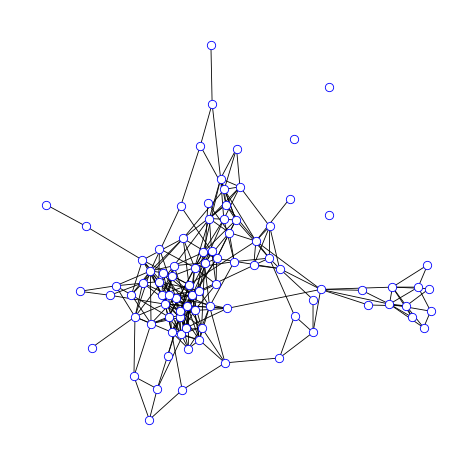

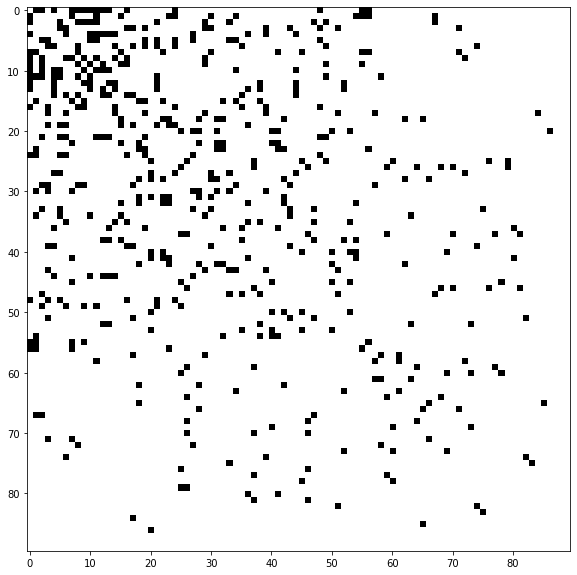

In [19]:
highschoolgraph = csv_to_graph("HighSchool")
print_graph(G=highschoolgraph)
plt.subplots(figsize=(10, 10))
plt.imshow(nx.to_numpy_array(highschoolgraph, nodelist=nodes_sorted_by_degree(highschoolgraph)), cmap='Greys', interpolation='none')
plt.show()

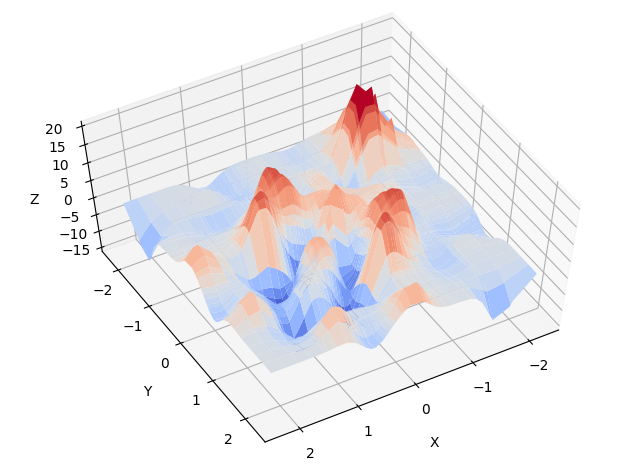

In [43]:
class LloydKernel():
    def __init__(self, lengthscale, signal_variance):
        self.lengthscale = lengthscale
        self.signal_variance = signal_variance

    def k_hat(self, xi1, xi2):
        if len(xi1.shape) == 2:
            padded_xi1 = np.expand_dims(xi1,1)
        else:
            padded_xi1 = xi1
        return np.square(self.signal_variance) * np.exp(-0.5 * np.square(np.linalg.norm(padded_xi1 - xi2, axis=-1) / self.lengthscale))

    def __call__(self, xi1, xi2):
        flipped_xi2 = np.flip(xi2, axis=-1)
        return 0.5*(self.k_hat(xi1, xi2) + self.k_hat(xi1, flipped_xi2))

pseudosize = 50
lengthscale = 0.2
signal_variance = 10.0
noise_variance = 0.01

etas = rng.multivariate_normal(np.zeros(pseudosize*2), np.identity(pseudosize*2)).reshape(pseudosize,2)

U = rng.multivariate_normal(np.zeros(len(highschoolgraph.nodes)), np.identity(len(highschoolgraph.nodes)))
xis = np.array([[a,b] for a in U for b in U])

k = LloydKernel(lengthscale, signal_variance)
k_etaeta = k(etas,etas)
Ts = rng.multivariate_normal(np.zeros(pseudosize), k_etaeta)

k_etaeta_inv = np.linalg.inv(k_etaeta)

k_xieta = k(xis,etas)

W_approx = k_xieta @ k_etaeta_inv @ Ts
W_approx = W_approx.reshape(len(highschoolgraph.nodes), len(highschoolgraph.nodes))

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111, projection='3d')
U_sorted, W_approx_sorted = sort_matrix_by_indices(U, W_approx)
X, Y = np.meshgrid(U_sorted, U_sorted)
ax.plot_surface(X, Y, W_approx_sorted, cmap=plt.cm.coolwarm)

ax.set_xlabel("\nX", linespacing=3.2)
ax.set_ylabel("\nY", linespacing=3.2)
ax.set_zlabel("\nZ", linespacing=3.2)

ax.view_init(60, 60)

plt.show()
